# Libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install --q torchsummary

# Custom_Resnet

In [3]:
# Define a ResNet block
class MyResNetBlock(nn.Module):
    # Constructor with input and output channel parameters
    def __init__(self, in_channels, out_channels):
        super(MyResNetBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        # ELU activation function
        self.activation1 = nn.ELU()
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    # Forward method for the block
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation1(x)
        return x

# Define the main ResNet model
class MyResNet(nn.Module):
    # Constructor
    def __init__(self):
        super(MyResNet, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.activation1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.activation2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Residual blocks
        self.resblock1 = MyResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.activation3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.activation4 = nn.ELU()
        self.resblock2 = MyResNetBlock(256, 256)

        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256, 256)
        self.dense2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    # Forward method for the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.maxpool1(x)

        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.maxpool2(x)

        x = self.conv4(x)
        x = self.activation4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x


In [4]:
from torchsummary import summary

# Instantiate the model
model = MyResNet()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
               ELU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
               ELU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          36,928
               ELU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
               ELU-9           [-1, 64, 16, 16]               0
    MyResNetBlock-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
              ELU-12          [-1, 128, 16, 16]               0
        MaxPool2d-13            [-1, 128, 8, 8]               0
           Conv2d-14            [-1, 25

# Dataset

In [5]:
# Data augmentation transformations for training data
data_augmentation_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by 15 degrees
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor values
])

# Data preprocessing transformations for test/validation data
data_preprocessing_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the tensor values
])


# Load CIFAR-10 dataset
# Training set with data augmentation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_augmentation_train)
# Test set with data preprocessing
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_preprocessing_test)

# Splitting the training dataset into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 128
# Training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 96339545.78it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Training

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyResNet().to(device)

In [7]:
# Optimizer, Learning Rate Scheduler, and Loss Criterion
# Stochastic Gradient Descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Learning rate scheduler with step decay
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
# CrossEntropyLoss criterion for classification tasks
criterion = nn.CrossEntropyLoss()

In [8]:
from tqdm import tqdm

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
best_model_weights = None

# Number of epochs
epochs = 100

# Training loop
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += data.size(0)

        total_loss += loss.item()

    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy_train = correct / total_samples

    print(f'Train Epoch: {epoch}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy_train:.2}')

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy_val = correct / len(val_loader.dataset)
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {accuracy_val:.2f}')

    # Append values for plotting
    train_losses.append(average_loss)
    train_accuracies.append(accuracy_train)

    # Append values for plotting
    val_losses.append(val_loss)
    val_accuracies.append(accuracy_val)

    if accuracy_val > best_val_accuracy:
       best_val_accuracy = accuracy_val
       best_model_weights = model.state_dict()

    scheduler.step()

100%|██████████| 352/352 [00:45<00:00,  7.70it/s]


Train Epoch: 1, Average Loss: 0.0180, Accuracy: 0.1
Validation set: Average loss: 0.0184, Accuracy: 0.09


100%|██████████| 352/352 [00:30<00:00, 11.62it/s]


Train Epoch: 2, Average Loss: 0.0180, Accuracy: 0.1
Validation set: Average loss: 0.0184, Accuracy: 0.09


100%|██████████| 352/352 [00:30<00:00, 11.46it/s]


Train Epoch: 3, Average Loss: 0.0180, Accuracy: 0.1
Validation set: Average loss: 0.0184, Accuracy: 0.09


100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Train Epoch: 4, Average Loss: 0.0180, Accuracy: 0.1
Validation set: Average loss: 0.0184, Accuracy: 0.09


100%|██████████| 352/352 [00:31<00:00, 11.16it/s]


Train Epoch: 5, Average Loss: 0.0180, Accuracy: 0.1
Validation set: Average loss: 0.0184, Accuracy: 0.09


100%|██████████| 352/352 [00:30<00:00, 11.56it/s]


Train Epoch: 6, Average Loss: 0.0179, Accuracy: 0.14
Validation set: Average loss: 0.0179, Accuracy: 0.18


100%|██████████| 352/352 [00:31<00:00, 11.32it/s]


Train Epoch: 7, Average Loss: 0.0175, Accuracy: 0.18
Validation set: Average loss: 0.0178, Accuracy: 0.20


100%|██████████| 352/352 [00:30<00:00, 11.44it/s]


Train Epoch: 8, Average Loss: 0.0174, Accuracy: 0.2
Validation set: Average loss: 0.0177, Accuracy: 0.22


100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Train Epoch: 9, Average Loss: 0.0173, Accuracy: 0.22
Validation set: Average loss: 0.0176, Accuracy: 0.23


100%|██████████| 352/352 [00:30<00:00, 11.60it/s]


Train Epoch: 10, Average Loss: 0.0172, Accuracy: 0.24
Validation set: Average loss: 0.0175, Accuracy: 0.25


100%|██████████| 352/352 [00:31<00:00, 11.24it/s]


Train Epoch: 11, Average Loss: 0.0171, Accuracy: 0.26
Validation set: Average loss: 0.0173, Accuracy: 0.29


100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Train Epoch: 12, Average Loss: 0.0170, Accuracy: 0.27
Validation set: Average loss: 0.0173, Accuracy: 0.27


100%|██████████| 352/352 [00:30<00:00, 11.43it/s]


Train Epoch: 13, Average Loss: 0.0169, Accuracy: 0.29
Validation set: Average loss: 0.0171, Accuracy: 0.30


100%|██████████| 352/352 [00:31<00:00, 11.35it/s]


Train Epoch: 14, Average Loss: 0.0167, Accuracy: 0.31
Validation set: Average loss: 0.0169, Accuracy: 0.33


100%|██████████| 352/352 [00:30<00:00, 11.57it/s]


Train Epoch: 15, Average Loss: 0.0166, Accuracy: 0.33
Validation set: Average loss: 0.0168, Accuracy: 0.35


100%|██████████| 352/352 [00:30<00:00, 11.66it/s]


Train Epoch: 16, Average Loss: 0.0164, Accuracy: 0.35
Validation set: Average loss: 0.0166, Accuracy: 0.38


100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Train Epoch: 17, Average Loss: 0.0163, Accuracy: 0.37
Validation set: Average loss: 0.0166, Accuracy: 0.38


100%|██████████| 352/352 [00:31<00:00, 11.07it/s]


Train Epoch: 18, Average Loss: 0.0162, Accuracy: 0.38
Validation set: Average loss: 0.0164, Accuracy: 0.40


100%|██████████| 352/352 [00:31<00:00, 11.08it/s]


Train Epoch: 19, Average Loss: 0.0162, Accuracy: 0.39
Validation set: Average loss: 0.0163, Accuracy: 0.41


100%|██████████| 352/352 [00:31<00:00, 11.01it/s]


Train Epoch: 20, Average Loss: 0.0161, Accuracy: 0.4
Validation set: Average loss: 0.0163, Accuracy: 0.41


100%|██████████| 352/352 [00:31<00:00, 11.33it/s]


Train Epoch: 21, Average Loss: 0.0160, Accuracy: 0.41
Validation set: Average loss: 0.0162, Accuracy: 0.42


100%|██████████| 352/352 [00:31<00:00, 11.17it/s]


Train Epoch: 22, Average Loss: 0.0159, Accuracy: 0.42
Validation set: Average loss: 0.0161, Accuracy: 0.44


100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Train Epoch: 23, Average Loss: 0.0158, Accuracy: 0.43
Validation set: Average loss: 0.0161, Accuracy: 0.44


100%|██████████| 352/352 [00:31<00:00, 11.15it/s]


Train Epoch: 24, Average Loss: 0.0157, Accuracy: 0.45
Validation set: Average loss: 0.0159, Accuracy: 0.46


100%|██████████| 352/352 [00:30<00:00, 11.56it/s]


Train Epoch: 25, Average Loss: 0.0157, Accuracy: 0.45
Validation set: Average loss: 0.0159, Accuracy: 0.46


100%|██████████| 352/352 [00:31<00:00, 11.24it/s]


Train Epoch: 26, Average Loss: 0.0156, Accuracy: 0.47
Validation set: Average loss: 0.0159, Accuracy: 0.46


100%|██████████| 352/352 [00:30<00:00, 11.44it/s]


Train Epoch: 27, Average Loss: 0.0155, Accuracy: 0.48
Validation set: Average loss: 0.0156, Accuracy: 0.50


100%|██████████| 352/352 [00:32<00:00, 11.00it/s]


Train Epoch: 28, Average Loss: 0.0153, Accuracy: 0.5
Validation set: Average loss: 0.0156, Accuracy: 0.51


100%|██████████| 352/352 [00:31<00:00, 11.14it/s]


Train Epoch: 29, Average Loss: 0.0152, Accuracy: 0.51
Validation set: Average loss: 0.0155, Accuracy: 0.52


100%|██████████| 352/352 [00:33<00:00, 10.40it/s]


Train Epoch: 30, Average Loss: 0.0151, Accuracy: 0.53
Validation set: Average loss: 0.0153, Accuracy: 0.55


100%|██████████| 352/352 [00:30<00:00, 11.51it/s]


Train Epoch: 31, Average Loss: 0.0150, Accuracy: 0.54
Validation set: Average loss: 0.0152, Accuracy: 0.55


100%|██████████| 352/352 [00:30<00:00, 11.40it/s]


Train Epoch: 32, Average Loss: 0.0149, Accuracy: 0.55
Validation set: Average loss: 0.0152, Accuracy: 0.56


100%|██████████| 352/352 [00:30<00:00, 11.51it/s]


Train Epoch: 33, Average Loss: 0.0148, Accuracy: 0.56
Validation set: Average loss: 0.0152, Accuracy: 0.55


100%|██████████| 352/352 [00:30<00:00, 11.45it/s]


Train Epoch: 34, Average Loss: 0.0148, Accuracy: 0.57
Validation set: Average loss: 0.0151, Accuracy: 0.57


100%|██████████| 352/352 [00:31<00:00, 11.31it/s]


Train Epoch: 35, Average Loss: 0.0147, Accuracy: 0.58
Validation set: Average loss: 0.0151, Accuracy: 0.57


100%|██████████| 352/352 [00:30<00:00, 11.56it/s]


Train Epoch: 36, Average Loss: 0.0146, Accuracy: 0.59
Validation set: Average loss: 0.0149, Accuracy: 0.60


100%|██████████| 352/352 [00:30<00:00, 11.37it/s]


Train Epoch: 37, Average Loss: 0.0146, Accuracy: 0.6
Validation set: Average loss: 0.0148, Accuracy: 0.60


100%|██████████| 352/352 [00:30<00:00, 11.50it/s]


Train Epoch: 38, Average Loss: 0.0145, Accuracy: 0.61
Validation set: Average loss: 0.0149, Accuracy: 0.59


100%|██████████| 352/352 [00:30<00:00, 11.47it/s]


Train Epoch: 39, Average Loss: 0.0144, Accuracy: 0.62
Validation set: Average loss: 0.0147, Accuracy: 0.62


100%|██████████| 352/352 [00:32<00:00, 10.90it/s]


Train Epoch: 40, Average Loss: 0.0144, Accuracy: 0.62
Validation set: Average loss: 0.0148, Accuracy: 0.60


100%|██████████| 352/352 [00:30<00:00, 11.49it/s]


Train Epoch: 41, Average Loss: 0.0143, Accuracy: 0.63
Validation set: Average loss: 0.0146, Accuracy: 0.64


100%|██████████| 352/352 [00:31<00:00, 11.16it/s]


Train Epoch: 42, Average Loss: 0.0143, Accuracy: 0.64
Validation set: Average loss: 0.0146, Accuracy: 0.63


100%|██████████| 352/352 [00:30<00:00, 11.65it/s]


Train Epoch: 43, Average Loss: 0.0142, Accuracy: 0.64
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:30<00:00, 11.65it/s]


Train Epoch: 44, Average Loss: 0.0142, Accuracy: 0.65
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:30<00:00, 11.64it/s]


Train Epoch: 45, Average Loss: 0.0141, Accuracy: 0.65
Validation set: Average loss: 0.0146, Accuracy: 0.64


100%|██████████| 352/352 [00:30<00:00, 11.53it/s]


Train Epoch: 46, Average Loss: 0.0141, Accuracy: 0.66
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:30<00:00, 11.38it/s]


Train Epoch: 47, Average Loss: 0.0141, Accuracy: 0.66
Validation set: Average loss: 0.0146, Accuracy: 0.63


100%|██████████| 352/352 [00:30<00:00, 11.50it/s]


Train Epoch: 48, Average Loss: 0.0140, Accuracy: 0.66
Validation set: Average loss: 0.0144, Accuracy: 0.66


100%|██████████| 352/352 [00:30<00:00, 11.43it/s]


Train Epoch: 49, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0145, Accuracy: 0.66


100%|██████████| 352/352 [00:31<00:00, 11.27it/s]


Train Epoch: 50, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:30<00:00, 11.58it/s]


Train Epoch: 51, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.37it/s]


Train Epoch: 52, Average Loss: 0.0137, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.57it/s]


Train Epoch: 53, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.54it/s]


Train Epoch: 54, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.61it/s]


Train Epoch: 55, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.66it/s]


Train Epoch: 56, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.48it/s]


Train Epoch: 57, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:30<00:00, 11.61it/s]


Train Epoch: 58, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Train Epoch: 59, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:31<00:00, 11.17it/s]


Train Epoch: 60, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.52it/s]


Train Epoch: 61, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.52it/s]


Train Epoch: 62, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.59it/s]


Train Epoch: 63, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.33it/s]


Train Epoch: 64, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Train Epoch: 65, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.53it/s]


Train Epoch: 66, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.65it/s]


Train Epoch: 67, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.72it/s]


Train Epoch: 68, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.33it/s]


Train Epoch: 69, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.30it/s]


Train Epoch: 70, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.51it/s]


Train Epoch: 71, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0141, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.70it/s]


Train Epoch: 72, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.67it/s]


Train Epoch: 73, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.70


100%|██████████| 352/352 [00:30<00:00, 11.53it/s]


Train Epoch: 74, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.69it/s]


Train Epoch: 75, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.18it/s]


Train Epoch: 76, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.41it/s]


Train Epoch: 77, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Train Epoch: 78, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.64it/s]


Train Epoch: 79, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0141, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.27it/s]


Train Epoch: 80, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.44it/s]


Train Epoch: 81, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.58it/s]


Train Epoch: 82, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.42it/s]


Train Epoch: 83, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.70it/s]


Train Epoch: 84, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.67it/s]


Train Epoch: 85, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.61it/s]


Train Epoch: 86, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:29<00:00, 11.78it/s]


Train Epoch: 87, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.53it/s]


Train Epoch: 88, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.63it/s]


Train Epoch: 89, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:31<00:00, 11.22it/s]


Train Epoch: 90, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.53it/s]


Train Epoch: 91, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.66it/s]


Train Epoch: 92, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.54it/s]


Train Epoch: 93, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.61it/s]


Train Epoch: 94, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.73it/s]


Train Epoch: 95, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.56it/s]


Train Epoch: 96, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.69it/s]


Train Epoch: 97, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:30<00:00, 11.64it/s]


Train Epoch: 98, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:30<00:00, 11.55it/s]


Train Epoch: 99, Average Loss: 0.0133, Accuracy: 0.76
Validation set: Average loss: 0.0139, Accuracy: 0.72


100%|██████████| 352/352 [00:31<00:00, 11.23it/s]


Train Epoch: 100, Average Loss: 0.0133, Accuracy: 0.77
Validation set: Average loss: 0.0139, Accuracy: 0.72


In [9]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}')

Test set: Average loss: 0.0136, Accuracy: 0.73


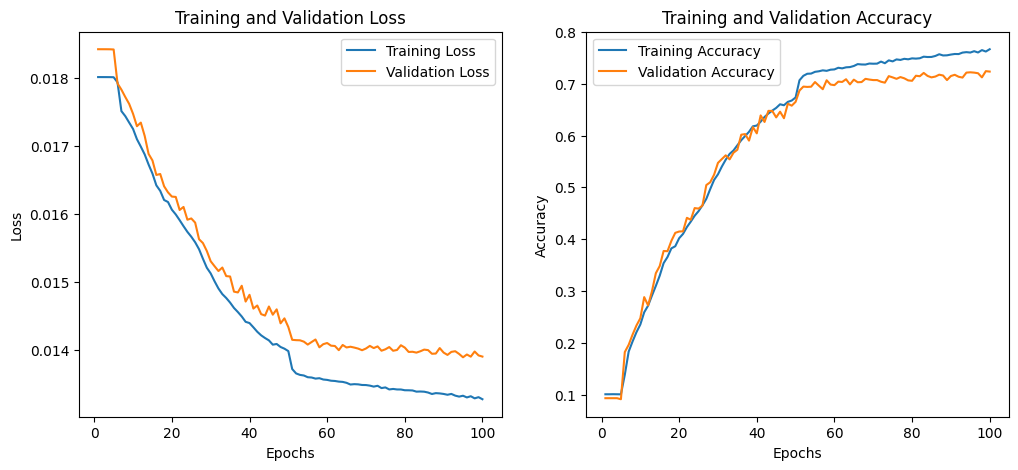

In [10]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [11]:
torch.save(model.state_dict(), 'trained_MyResNet_No_skip.pth')

# Metrics

In [4]:
!git clone https://github.com/K-Hooshanfar/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 6.29 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex
import torch
from tqdm import tqdm

In [5]:
# Load the pre-trained model
state_dict = torch.load('/content/trained_MyResNet_No_skip.pth')

model = MyResNet()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Convert test_dataset to a list or NumPy array
test_data_list = [(img, label) for img, label in test_dataset]

# Further split train_dataset into train_loader_dataset and 10% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.1 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Similarly, for the test_loader
test_loader_dataset, _ = train_test_split(test_data_list, train_size=int(0.1 * len(test_dataset)),
                                          test_size=None, shuffle=True, stratify=test_dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_loader_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
features_per_layer = {}
labels = []

# Get the total number of layers in the model
total_layers = len(list(model.children()))

# Exclude the last four layers
layers_to_be_deleted = set(list(model.children())[-4:])

# Attach hooks to each layer except the excluded ones
features_per_layer = {}
for name, layer in model.named_children():
    if layer not in layers_to_be_deleted:
        features_per_layer[name] = []
        def hook(module, input, output, name=name):
            features_per_layer[name].append(output.detach())
        layer.register_forward_hook(hook)

In [10]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 36/36 [00:07<00:00,  4.68it/s]


# SI

In [11]:
si_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 432.69it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2372.34it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2579.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3255.94it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3365.67it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3415.56it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2613.27it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2756.51it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3262.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3962.87it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3069.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2037.26it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3589.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3622.65it/s]


In [12]:
si_train

[('conv1', 0.2226666659116745),
 ('activation1', 0.22333332896232605),
 ('conv2', 0.20733334124088287),
 ('activation2', 0.21044445037841797),
 ('maxpool1', 0.29466667771339417),
 ('resblock1', 0.3871111273765564),
 ('maxpool2', 0.47066667675971985),
 ('conv3', 0.4360000193119049),
 ('activation3', 0.41111111640930176),
 ('maxpool3', 0.5344444513320923),
 ('conv4', 0.5217778086662292),
 ('activation4', 0.4868888854980469),
 ('resblock2', 0.6331111192703247),
 ('avgpool', 0.6662222146987915)]

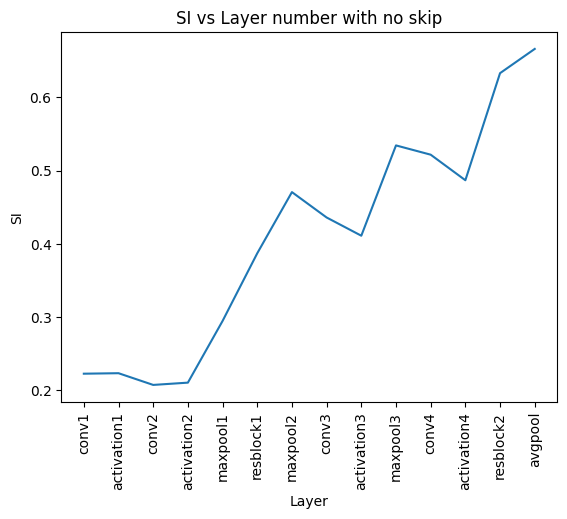

In [13]:
plt.plot([layer for layer, _ in si_train], [si for _, si in si_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number with no skip')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [14]:
csi_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1616.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1302.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1715.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1502.69it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1011.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 935.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1912.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1954.48it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1853.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1536.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1171.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1294.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1320.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1458.08it/s]


In [15]:
csi_train

[('conv1', 0.3517777919769287),
 ('activation1', 0.359333336353302),
 ('conv2', 0.3633333444595337),
 ('activation2', 0.390666663646698),
 ('maxpool1', 0.4519999921321869),
 ('resblock1', 0.5211111307144165),
 ('maxpool2', 0.5537777543067932),
 ('conv3', 0.5108888745307922),
 ('activation3', 0.5479999780654907),
 ('maxpool3', 0.6075555682182312),
 ('conv4', 0.550000011920929),
 ('activation4', 0.6037777662277222),
 ('resblock2', 0.6933333277702332),
 ('avgpool', 0.7324444651603699)]

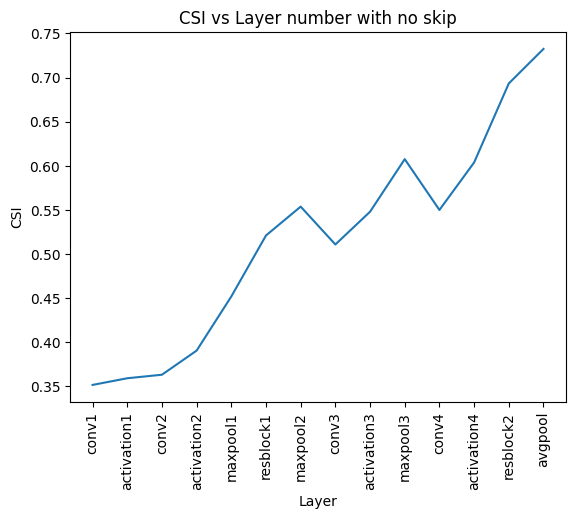

In [16]:
plt.plot([layer for layer, _ in csi_train], [si for _, si in csi_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI vs Layer number with no skip')
plt.xticks(rotation=90)
plt.show()

# Metrics of Test Loader

In [9]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 8/8 [00:01<00:00,  5.48it/s]


# SI

In [10]:
si_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 928.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2755.78it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1152.91it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 607.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 403.73it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1833.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2937.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 571.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1829.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2991.66it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3187.16it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 766.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2864.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3039.35it/s]


In [11]:
si_test

[('conv1', 0.18700000643730164),
 ('activation1', 0.1900000125169754),
 ('conv2', 0.1850000023841858),
 ('activation2', 0.17600001394748688),
 ('maxpool1', 0.24500000476837158),
 ('resblock1', 0.3150000274181366),
 ('maxpool2', 0.4010000228881836),
 ('conv3', 0.3500000238418579),
 ('activation3', 0.34200000762939453),
 ('maxpool3', 0.4540000259876251),
 ('conv4', 0.43400001525878906),
 ('activation4', 0.4000000059604645),
 ('resblock2', 0.5640000104904175),
 ('avgpool', 0.6130000352859497)]

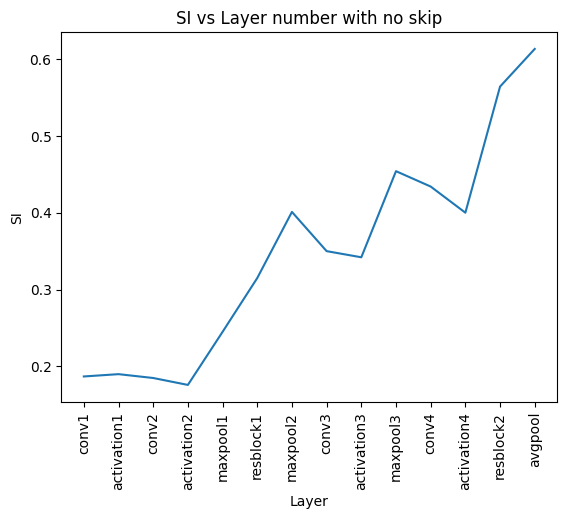

In [12]:
plt.plot([layer for layer, _ in si_test], [si for _, si in si_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number with no skip')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [13]:
csi_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1276.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 927.74it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 824.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 900.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 332.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1063.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1279.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1572.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 336.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1350.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 609.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 897.75it/s]

Data has been normalized

Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 878.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1281.09it/s]


In [14]:
csi_test

[('conv1', 0.46800002455711365),
 ('activation1', 0.47700002789497375),
 ('conv2', 0.5049999952316284),
 ('activation2', 0.5240000486373901),
 ('maxpool1', 0.5440000295639038),
 ('resblock1', 0.5820000171661377),
 ('maxpool2', 0.625),
 ('conv3', 0.5690000057220459),
 ('activation3', 0.6380000114440918),
 ('maxpool3', 0.6830000281333923),
 ('conv4', 0.5940000414848328),
 ('activation4', 0.6960000395774841),
 ('resblock2', 0.7010000348091125),
 ('avgpool', 0.706000030040741)]

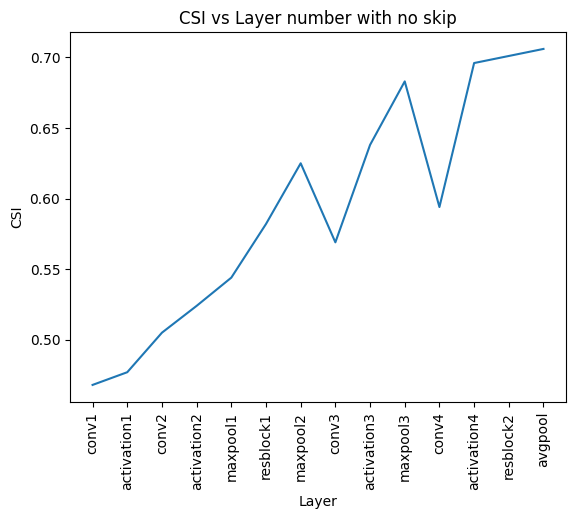

In [15]:
plt.plot([layer for layer, _ in csi_test], [si for _, si in csi_test])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI vs Layer number with no skip')
plt.xticks(rotation=90)
plt.show()